# House Prices in Poland

<span id = "1"></span>
# The Data

<br>
<br>
<p>The dataset was collected by me. The data come from one of the websites, where we can find advertisements of the sale of apartments. The data is from February 2021.</p>

<br>
Description:
<ul>
    <li>address - Full addres
    <li>city - Warszawa (Warsaw), Kraków (Cracow), Poznań (Poznan).
    <li>floor - The number of the floor where the apartment is located
    <li>id - id
    <li>latitude - latitude
    <li>longitude - longitude
    <li>price - Price of apartment in PLN [TARGET]
    <li>rooms - Number of rooms in the apartment
    <li>sq - Number of square meters of the apartment
    <li>year - Year of the building / apartment 
</ul>

# Contents
<br></br>
<br></br>
[1. The Data](#1)
<br></br>

<br></br>
[2. Imports and Pre-cleaning](#2)
<br></br>

<br></br>
[3. Feature Engineering and Data Cleaning](#3)
<br></br>

&emsp; [3.1. Feature Engineering](#3.1) <br>
&emsp; [3.2. Outliers removal](#3.2)


<br></br>
[4. Exploratory Data Analysis](#4)

<br></br>
[5. Apartments Location Heatmap](#5)
<br></br>

<br></br>
[6. Regression Model](#6)
<br></br>

<br></br>
[7. Model Evaluation](#7)
<br></br>

<span id = "2"></span>
# Imports and Pre-cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import xgboost
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

import folium
from folium import plugins
from folium.plugins import HeatMap, FastMarkerCluster

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

In [2]:
df = pd.read_csv("Houses_raw.csv", encoding='ISO-8859-2')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30308 entries, 0 to 30307
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         30308 non-null  object
 1   price      30298 non-null  object
 2   sq         30298 non-null  object
 3   rooms      30298 non-null  object
 4   floor      30298 non-null  object
 5   year       30298 non-null  object
 6   address    30298 non-null  object
 7   city       30298 non-null  object
 8   latitude   30298 non-null  object
 9   longitude  30298 non-null  object
dtypes: object(10)
memory usage: 2.3+ MB


In [4]:
df.head(3)

,id,price,sq,rooms,floor,year,address,city,latitude,longitude
0,1,355000.0,55.0,3,1,2020,wielkopolskie,Poznań,52.4006632,16.91973259178088
1,2,213620.0,29.4,1,0,None,wielkopolskie,Poznań,52.4006632,16.91973259178088
2,3,388000.0,55.5,3,2,None,wielkopolskie,Poznań,52.4006632,16.91973259178088


In [5]:
print('Price None:')
print(len(df[df.price == "None"]))
df = df.drop(df[df.price == "None"].index)

print('City != Poznań, Warszawa, Kraków:')
print(len(df[(df.city != "Poznań") & (df.city != "Warszawa") & (df.city != "Kraków")]))
df = df.drop(df[(df.city != "Poznań") & (df.city != "Warszawa") & (df.city != "Kraków")].index)

print('Rooms None:')
print(len(df[df.rooms == "None"]))
df = df.drop(df[df.rooms == "None"].index)

print('Year None:')
print(len(df[df.year == "None"]))
df = df.drop(df[df.year == "None"].index)

print('Floor None:')
print(len(df[df.floor == "None"]))
df = df.drop(df[df.floor == "None"].index)

print('\ndf len:')
print(len(df))

Price None:
1747
City != Poznań, Warszawa, Kraków:
207
Rooms None:
12
Year None:
4023
Floor None:
519

df len:
23800


In [6]:
# checking unique for floor
df.floor.unique()

array(['1', '3', '2', '0', '4', '5', '10', '6', '7', '> 10', '9', '8',
       'suterena', 'poddasze'], dtype=object)

In [7]:
# overall 3 values different than number

# 1 - "suterena", 2 - "poddasze"
# how many are there?
len(df[(df.floor == "suterena") | (df.floor == "poddasze")])

36

In [8]:
# only 36, so drop
df = df.drop(df[(df.floor == "suterena") | (df.floor == "poddasze")].index)
len(df)

23764

In [9]:
# 3 - ""> 10"
len(df[df.floor == "> 10"])

440

In [10]:
# changing >10 to 10
df['floor'] = df['floor'].replace('> 10', 10)

df.floor.unique()

array(['1', '3', '2', '0', '4', '5', '10', '6', '7', 10, '9', '8'],
      dtype=object)

In [11]:
# setting the dtype of features
df2 = df.astype({"id": int, "price": float, "sq": float, "rooms": int, "year": int, 
                 "floor": int, "address": str, "city": str, "latitude": float, "longitude": float}) 

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23764 entries, 0 to 30307
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         23764 non-null  int32  
 1   price      23764 non-null  float64
 2   sq         23764 non-null  float64
 3   rooms      23764 non-null  int32  
 4   floor      23764 non-null  int32  
 5   year       23764 non-null  int32  
 6   address    23764 non-null  object 
 7   city       23764 non-null  object 
 8   latitude   23764 non-null  float64
 9   longitude  23764 non-null  float64
dtypes: float64(4), int32(4), object(2)
memory usage: 1.6+ MB


In [13]:
# reset index, return whole set (sample) with new setted index
df2 = df2.sample(frac=1).reset_index(drop=True)

df2.head()

,id,price,sq,rooms,floor,year,address,city,latitude,longitude
0,4936,766300.0,94.74,4,0,2020,Jeżyce Winiary,Poznań,52.422602,16.917530
1,10814,3550000.0,238.00,6,2,2000,Żoliborz Sady Żoliborskie Sady Żoliborskie,Warszawa,52.258425,20.967545
2,84,450000.0,55.00,2,3,1962,Grunwald ul. Rycerska,Poznań,52.400673,16.880690
3,20846,599000.0,69.00,3,0,1950,Nowa Huta,Kraków,50.080619,20.129332
4,12208,568000.0,57.60,3,2,1992,Praga-Północ,Warszawa,52.264884,21.027344


In [14]:
# save clean version of data frame to csv
# df2.to_csv('Houses.csv', index = False)

In [15]:
df2 = pd.read_csv('Houses.csv', encoding='ISO-8859-2', index_col=0)

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23764 entries, 0 to 23763
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   address    23764 non-null  object 
 1   city       23764 non-null  object 
 2   floor      23764 non-null  float64
 3   id         23764 non-null  float64
 4   latitude   23764 non-null  float64
 5   longitude  23764 non-null  float64
 6   price      23764 non-null  float64
 7   rooms      23764 non-null  float64
 8   sq         23764 non-null  float64
 9   year       23764 non-null  float64
dtypes: float64(8), object(2)
memory usage: 2.0+ MB


In [17]:
df2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
floor,23764.0,2.808744,2.463467,0.000000,1.000000,2.000000,4.000000,1.000000e+01
id,23764.0,15621.964484,8617.293898,1.000000,8420.750000,15637.500000,23111.250000,3.030800e+04
latitude,23764.0,51.374874,1.099836,49.933056,50.066489,52.193987,52.267594,5.443524e+01
longitude,23764.0,19.861773,1.447186,4.204796,19.916563,19.999330,20.996180,3.031940e+01
price,23764.0,649353.647809,532696.986646,5000.000000,411546.125000,520000.000000,699999.000000,1.500000e+07
rooms,23764.0,2.620771,0.996530,1.000000,2.000000,3.000000,3.000000,1.000000e+01
sq,23764.0,102.724910,6533.687932,8.800000,42.000000,53.895000,68.915000,1.007185e+06
year,23764.0,2000.551170,48.314020,70.000000,1985.000000,2019.000000,2021.000000,2.980000e+03


<span id = "3"></span>
# Feature Engineering and Data Cleaning

<span id = "3.1"></span>
#### Feature Engineering

In [18]:
df3 = df2.copy()

# create new column,which tells us: what is the price per square meter?
df3['price_per_sqmeter'] = df3['price'] / df3['sq']
df3.head()

,address,city,floor,id,latitude,longitude,price,rooms,sq,year,price_per_sqmeter
0,Podgórze Zabłocie Stanisława Klimeckiego,Kraków,2.0,23918.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0,10114.787306
1,Praga-Południe Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0,9866.611977
2,Krowodrza Czarnowiejska,Kraków,2.0,22784.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0,11540.540541
3,Grunwald,Poznań,2.0,4315.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0,7771.084337
4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,11770.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0,9485.714286


In [19]:
df4 = df3

# create new column, which tells us: how many square meters per room?
df4['sqm_per_room'] = df4['sq'] / df4['rooms']
df4.head()

,address,city,floor,id,latitude,longitude,price,rooms,sq,year,price_per_sqmeter,sqm_per_room
0,Podgórze Zabłocie Stanisława Klimeckiego,Kraków,2.0,23918.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0,10114.787306,24.683333
1,Praga-Południe Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0,9866.611977,24.380000
2,Krowodrza Czarnowiejska,Kraków,2.0,22784.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0,11540.540541,18.500000
3,Grunwald,Poznań,2.0,4315.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0,7771.084337,33.200000
4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,11770.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0,9485.714286,21.000000


<span id = "3.2"></span>
#### Outliers Removal 

In [20]:
## sq
df4.sort_values('sq')

,address,city,floor,id,latitude,longitude,price,rooms,sq,year,price_per_sqmeter,sqm_per_room
1349,Targówek Rembrandta,Warszawa,4.0,12911.0,52.231958,21.006725,1220000.0,4.0,8.80,2019.0,138636.363636,2.20
19580,ródmiecie,Warszawa,0.0,17091.0,52.232810,21.019067,225000.0,1.0,11.00,1968.0,20454.545455,11.00
6847,Wola,Warszawa,0.0,7591.0,52.236238,20.954781,215000.0,1.0,11.74,1961.0,18313.458262,11.74
2155,Krowodrza ul. Juliusza Lea,Kraków,0.0,26812.0,50.070360,19.918877,229000.0,1.0,12.00,2018.0,19083.333333,12.00
1749,Wola Młynów Zawiszy,Warszawa,0.0,14323.0,52.243417,20.962176,217000.0,1.0,12.80,1936.0,16953.125000,12.80
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,Krowodrza Armii Krajowej,Kraków,4.0,19707.0,50.070065,19.897989,6299000.0,10.0,442.20,2017.0,14244.685663,44.22
13662,Krowodrza Jana Buszka,Kraków,4.0,30031.0,50.067447,19.902934,6299000.0,10.0,442.20,2017.0,14244.685663,44.22
18637,Stare Miasto Naramowice,Poznań,1.0,1517.0,52.400663,16.919733,544169.0,4.0,8065.00,2021.0,67.472908,2016.25
10798,Wawer ul. Przylaszczkowa,Warszawa,1.0,12896.0,52.231958,21.006725,389880.0,2.0,9000.00,2022.0,43.320000,4500.00


In [21]:
# Create list of rows with mistakenly sq value
out_sq = df4[(df4['sq'] > 450) | (df4['sq'] < 10)].index.tolist()

# Remove 
df4 = df4.drop(out_sq)

In [22]:
## year
df4.sort_values('year')

,address,city,floor,id,latitude,longitude,price,rooms,sq,year,price_per_sqmeter,sqm_per_room
7659,Nowe Miasto Głuszyna,Poznań,2.0,1603.0,52.326362,16.962886,235000.0,2.0,40.50,70.0,5802.469136,20.250000
1032,ródmiecie Żurawia,Warszawa,1.0,14485.0,52.231958,21.006725,760000.0,3.0,53.00,75.0,14339.622642,17.666667
14431,Stare Miasto Pištkowo os. Bolesława Chrobrego,Poznań,1.0,640.0,52.400663,16.919733,375000.0,3.0,64.00,80.0,5859.375000,21.333333
4513,Wola Krochmalna,Warszawa,10.0,13832.0,52.231958,21.006725,320000.0,1.0,28.00,80.0,11428.571429,28.000000
10408,Bemowo ul. Karabeli,Warszawa,9.0,8116.0,52.231958,21.006725,450000.0,2.0,47.80,81.0,9414.225941,23.900000
...,...,...,...,...,...,...,...,...,...,...,...,...
10463,wielkopolskie,Poznań,0.0,2195.0,52.400663,16.919733,358100.0,2.0,48.00,2023.0,7460.416667,24.000000
6612,Podgórze Płaszów Myliwska,Kraków,2.0,26829.0,50.045459,20.000203,402000.0,2.0,46.65,2023.0,8617.363344,23.325000
8941,Podgórze Płaszów Myliwska,Kraków,1.0,26536.0,50.045459,20.000203,361000.0,2.0,43.81,2023.0,8240.127825,21.905000
13963,Wola,Warszawa,1.0,6527.0,52.236238,20.954781,499497.0,1.0,31.29,2024.0,15963.470757,31.290000


In [23]:
# Create list of rows with mistakenly year value
out_year = df4[(df4['year'] > 2024) | (df4['year'] < 1200)].index.tolist()

# Remove 
df4 = df4.drop(out_year)

In [24]:
## sqm_per_room
df4.sort_values('sqm_per_room', ascending = True)

,address,city,floor,id,latitude,longitude,price,rooms,sq,year,price_per_sqmeter,sqm_per_room
17507,Ursus ul. Konińska 1,Warszawa,3.0,10404.0,52.231958,21.006725,309990.0,10.0,26.00,1962.0,11922.692308,2.600000
12613,Krowodrza,Kraków,5.0,28484.0,50.070880,19.916563,549585.0,5.0,40.71,2020.0,13500.000000,8.142000
4307,Warszawa mazowieckie,Warszawa,9.0,10246.0,52.283481,20.936441,499000.0,5.0,41.32,1974.0,12076.476283,8.264000
10535,Stare Miasto w. Sebastiana,Kraków,0.0,28268.0,50.046943,19.997153,369000.0,3.0,25.00,1910.0,14760.000000,8.333333
23634,Bieńczyce os. Przy Arce,Kraków,10.0,25143.0,50.046943,19.997153,390000.0,4.0,38.00,1970.0,10263.157895,9.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
12632,Stare Miasto Rakowicka,Kraków,5.0,23715.0,50.046943,19.997153,2850000.0,1.0,177.59,1921.0,16048.200912,177.590000
13726,Podgórze ul. Zabłocie 27,Kraków,0.0,19349.0,50.047877,19.961369,1880700.0,1.0,188.07,2021.0,10000.000000,188.070000
4064,Grzegórzki,Kraków,2.0,24200.0,50.064972,19.968826,908000.0,1.0,189.00,1950.0,4804.232804,189.000000
18636,Nowe Miasto Rataje,Poznań,1.0,4736.0,52.400663,16.919733,347776.0,2.0,379.52,2021.0,916.357504,189.760000


In [25]:
# mean sqm_per_room
df4['sqm_per_room'].mean()

23.26688182129294

In [26]:
# How many rows are there more square meters per room than 51?
len(df4[df4['sqm_per_room'] > 51])

91

In [27]:
# How many rows are there less square meters per room than 10?
len(df4[df4['sqm_per_room'] < 10])

5

In [28]:
# Create a list of these rows
out_sqm_per_room = df4[(df4['sqm_per_room'] > 51) | (df4['sqm_per_room'] < 10)].index.tolist()

# Remove 
df5 = df4.drop(out_sqm_per_room)

In [29]:
## price_per_sqmeter
df5.sort_values('price_per_sqmeter')

,address,city,floor,id,latitude,longitude,price,rooms,sq,year,price_per_sqmeter,sqm_per_room
10084,Wola Muranów Pokorna 2,Warszawa,1.0,6483.0,52.231958,21.006725,5000.0,2.0,50.00,2009.0,100.000000,25.000000
22783,Wilda,Poznań,1.0,3363.0,52.389775,16.917438,29900.0,2.0,49.00,2003.0,610.204082,24.500000
10382,Wzgórza Krzesławickie Łuczanowice,Kraków,1.0,27998.0,50.046943,19.997153,200000.0,6.0,185.00,1986.0,1081.081081,30.833333
11867,Stare Miasto Winogrady,Poznań,5.0,4182.0,52.400663,16.919733,79900.0,3.0,48.50,2000.0,1647.422680,16.166667
3906,Krowodrza Obożna( rejon),Kraków,2.0,28581.0,50.453340,30.319403,429000.0,7.0,207.00,1936.0,2072.463768,29.571429
...,...,...,...,...,...,...,...,...,...,...,...,...
13670,ródmiecie Złota,Warszawa,10.0,6551.0,52.230955,21.001176,5260000.0,3.0,108.45,2017.0,48501.613647,36.150000
16299,ródmiecie Złota,Warszawa,10.0,9959.0,52.230955,21.001176,3114000.0,2.0,63.30,2017.0,49194.312796,31.650000
20292,ródmiecie Złota,Warszawa,10.0,11980.0,52.230955,21.001176,7500000.0,3.0,150.00,2015.0,50000.000000,50.000000
21892,Bemowo Batalionów Chłopskich,Warszawa,4.0,6725.0,52.231958,21.006725,6053000.0,3.0,60.67,2022.0,99769.243448,20.223333


In [30]:
df5[(df5['price_per_sqmeter'] > 58000.0) | (df5['price_per_sqmeter'] < 2000.0)]

,address,city,floor,id,latitude,longitude,price,rooms,sq,year,price_per_sqmeter,sqm_per_room
10084,Wola Muranów Pokorna 2,Warszawa,1.0,6483.0,52.231958,21.006725,5000.0,2.0,50.00,2009.0,100.000000,25.000000
10382,Wzgórza Krzesławickie Łuczanowice,Kraków,1.0,27998.0,50.046943,19.997153,200000.0,6.0,185.00,1986.0,1081.081081,30.833333
11867,Stare Miasto Winogrady,Poznań,5.0,4182.0,52.400663,16.919733,79900.0,3.0,48.50,2000.0,1647.422680,16.166667
20669,Mokotów,Warszawa,3.0,10973.0,52.193987,21.045781,9008000.0,4.0,79.41,2022.0,113436.594887,19.852500
21892,Bemowo Batalionów Chłopskich,Warszawa,4.0,6725.0,52.231958,21.006725,6053000.0,3.0,60.67,2022.0,99769.243448,20.223333
22783,Wilda,Poznań,1.0,3363.0,52.389775,16.917438,29900.0,2.0,49.00,2003.0,610.204082,24.500000


In [31]:
# Create a list of rows where price_per_sqmeter > 58k and price_per_sqmeter < 2k
out_price_per_sqmeter = df5[(df5['price_per_sqmeter'] > 58000.0) | (df5['price_per_sqmeter'] < 2000.0)].index.tolist()
out_price_per_sqmeter

[10084, 10382, 11867, 20669, 21892, 22783]

In [32]:
# remove these rows
df5 = df5.drop(out_price_per_sqmeter)

In [33]:
df5.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
floor,23646.0,2.806986,2.459974,0.000000,1.000000,2.000000,4.000000,1.000000e+01
id,23646.0,15631.624207,8615.632021,1.000000,8437.250000,15670.500000,23115.750000,3.030800e+04
latitude,23646.0,51.373540,1.100082,49.933056,50.066544,52.193987,52.267594,5.443524e+01
longitude,23646.0,19.862552,1.446061,4.204796,19.916563,20.000203,20.995471,3.031940e+01
price,23646.0,641818.632199,481409.140156,69000.000000,410994.000000,520000.000000,699000.000000,1.095000e+07
rooms,23646.0,2.621035,0.991550,1.000000,2.000000,3.000000,3.000000,1.000000e+01
sq,23646.0,59.279157,27.159272,11.000000,42.000000,53.840000,68.695000,4.422000e+02
year,23646.0,2001.326059,29.936040,1390.000000,1985.000000,2019.000000,2021.000000,2.024000e+03
price_per_sqmeter,23646.0,10735.709083,3589.341354,2072.463768,8400.089366,9946.879150,12313.614204,5.000000e+04
sqm_per_room,23646.0,23.089249,5.759247,10.205000,19.000000,22.000000,25.855000,5.100000e+01


<span id = "4"></span>
# EDA

Text(0.5, 1.0, 'Count of sales announcement in a given city')

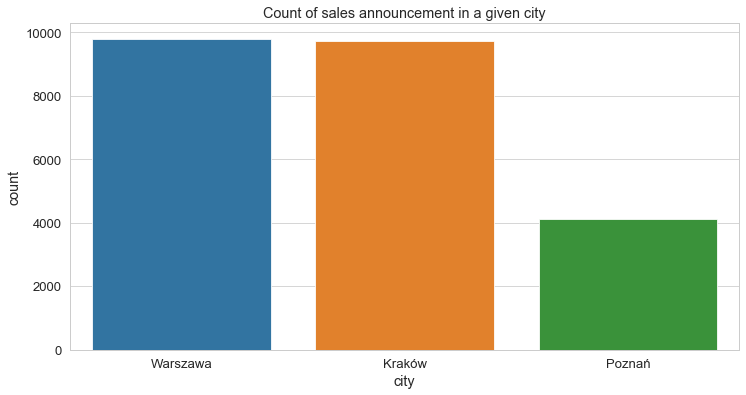

In [34]:
# Count of sales announcement in a given city
plt.figure(figsize=(12,6))
sns.countplot(x = 'city', data = df5, 
              order = ['Warszawa', 'Kraków', 
                       'Poznań']).set_title("Count of sales announcement in a given city")

<p>In total, in the three cities we have a little less than 24,000 housing ads.
Warsaw and Krakow are on a similar level with slightly less than 10,000 ads per city. Poznań has around 4,000 ads.</p>

Text(0.5, 1.0, 'Histogram of price per square meter')

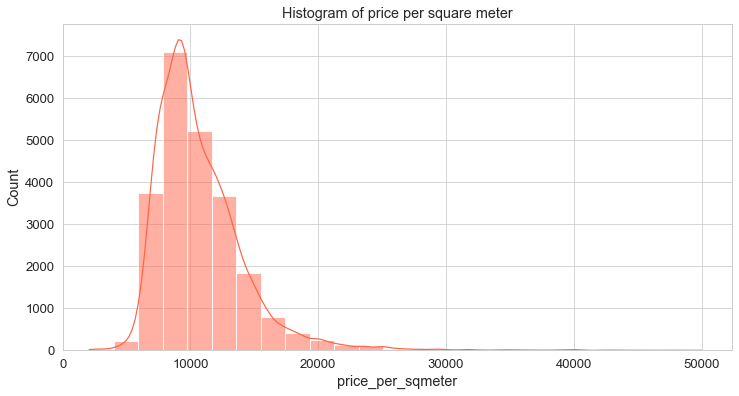

In [35]:
# Histogram of price per square meter
plt.figure(figsize=(12,6))
g = sns.histplot(x = 'price_per_sqmeter', data = df5, bins = 25, color = 'tomato', 
                 kde = True)
g.set(xlim=(0, None))
g.set_title('Histogram of price per square meter')


<p>The average price per square meter, taking into account the three cities, is PLN 10.735.</p>


Text(0.5, 1.0, 'Histogram of an apartments prices')

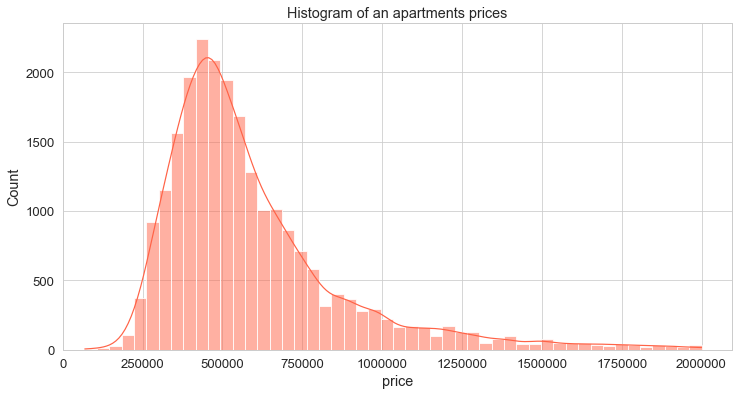

In [36]:
# Histogram of an apartments prices closer look
plt.figure(figsize=(12,6))
plt.ticklabel_format(style='plain', axis='x')
g = sns.histplot(x = 'price', data = df5[df5['price'] < 2000000], bins = 50, color = 'tomato', 
                 kde = True)
g.set(xlim=(0, None))
g.set_title('Histogram of an apartments prices')

<p>The average price for an apartment, taking three cities into account, is PLN 641.818.</p>

<p>How do these prices look for individual cities?</p>

Text(0.5, 1.0, 'Histogram of price per square meter in Poznań')

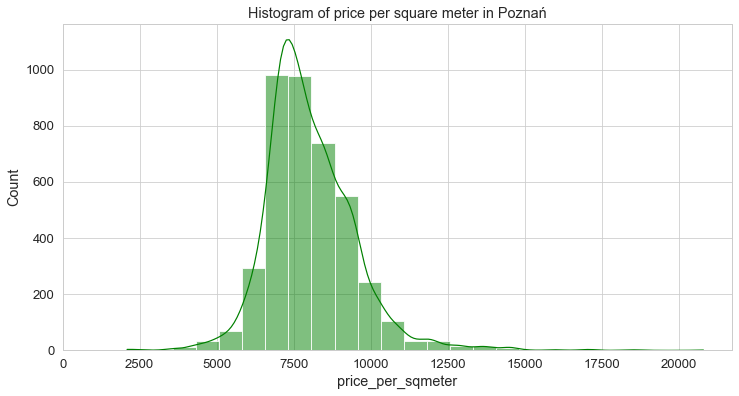

In [37]:
# Histogram of price per square meter in Poznań
plt.figure(figsize=(12,6))
g = sns.histplot(x = 'price_per_sqmeter', data = df5[df5['city'] == "Poznań"], bins = 25, color = 'green', 
                 kde = True)
g.set(xlim=(0, None))
g.set_title('Histogram of price per square meter in Poznań')

<p>In Poznań, the average price per square meter is PLN 8.500.</p>
<p>However, it can be noticed that in most of the sale announcements it is around PLN 7.500.</p>

Text(0.5, 1.0, 'Histogram of an apartments prices in Poznań')

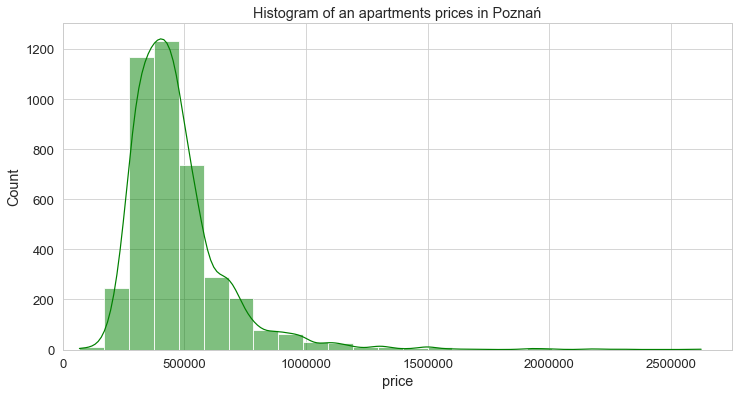

In [38]:
# Histogram of an apartments prices in Poznań
plt.figure(figsize=(12,6))
g = sns.histplot(x = 'price', data = df5[df5['city'] == "Poznań"], bins = 25, color = 'green', 
                 kde = True)
g.set(xlim=(0, None))
g.set_title('Histogram of an apartments prices in Poznań')

<p>When it comes to the price of an apartment, in Poznań we have to pay an average of PLN 467.000.</p>

<p>How does it look like in Warsaw?</p>

Text(0.5, 1.0, 'Histogram of price per square meter in Warszawa')

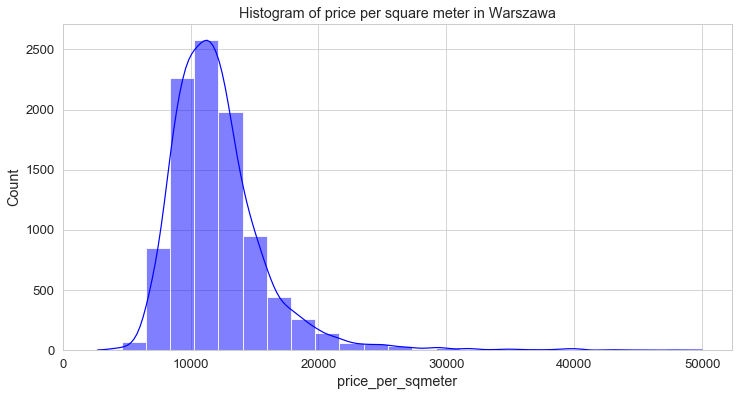

In [39]:
# Histogram of price per square meter in Warszawa
plt.figure(figsize=(12,6))
g = sns.histplot(x = 'price_per_sqmeter', data = df5[df5['city'] == "Warszawa"], bins = 25, color = 'blue', 
                 kde = True)
g.set(xlim=(0, None))
g.set_title('Histogram of price per square meter in Warszawa')

<p>In Warsaw, the average price per square meter is PLN 12.000.</p>

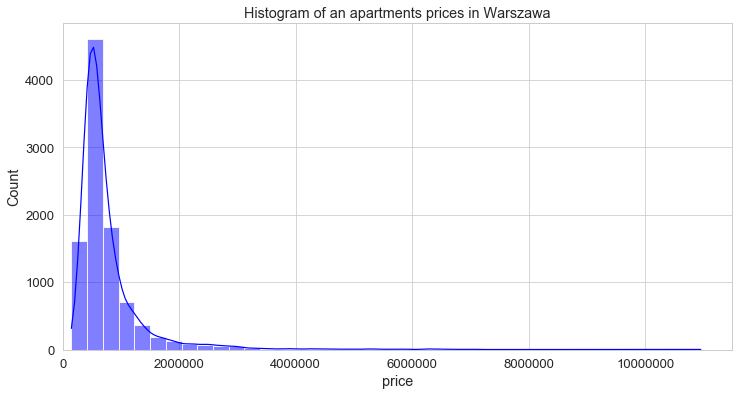

In [40]:
# Histogram of an apartments prices in Warszawa
plt.figure(figsize=(12,6))

g = sns.histplot(x = 'price', data = df5[df5['city'] == "Warszawa"], bins = 40, color = 'blue', 
                 kde = True)

g.set(xlim=(0, None))
g.set_title('Histogram of an apartments prices in Warszawa')
plt.ticklabel_format(style='plain', axis='x')

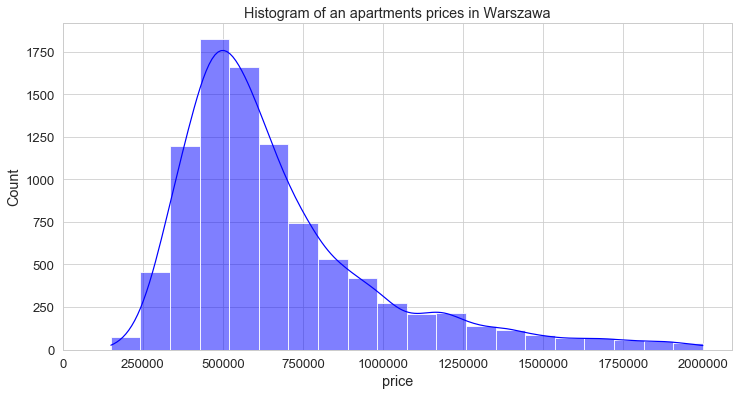

In [41]:
# Histogram of an apartments prices in Warszawa closer look
plt.figure(figsize=(12,6))

g = sns.histplot(x = 'price', data = df5[(df5['city'] == "Warszawa") & (df5['price'] < 2000000)], 
                 bins = 20, color = 'blue', kde = True)

g.set(xlim=(0, None))
g.set_title('Histogram of an apartments prices in Warszawa')
plt.ticklabel_format(style='plain', axis='x')

<p>When it comes to the price of an apartment, in Warsaw we have to pay an average of PLN 766.000.</p>
<p>However, it can be noticed that in most of the sale announcements it is around PLN 450,000 - 550.000 for apartment.</p>

<p>How does it look like in Cracow?</p>

Text(0.5, 1.0, 'Count of price per square meter in Kraków')

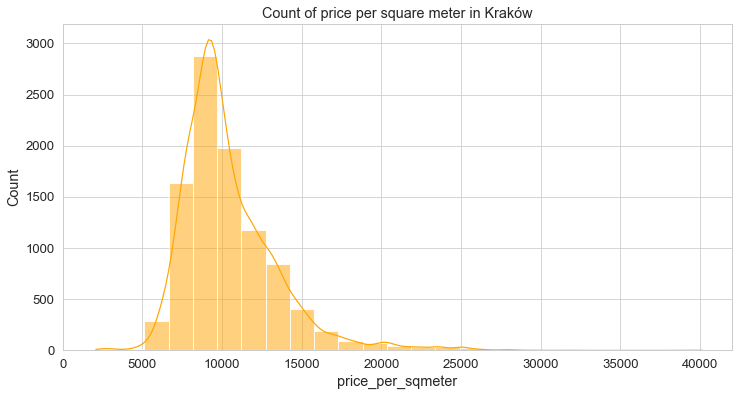

In [42]:
# Count of price per square meter in Kraków
plt.figure(figsize=(12,6))
g = sns.histplot(x = 'price_per_sqmeter', data = df5[df5['city'] == "Kraków"], bins = 25, color = 'orange',
                kde = True)
g.set(xlim=(0, None))
g.set_title('Count of price per square meter in Kraków')

<p>In Krakow, the average price per square meter is PLN 10.000.
However, it can be noticed that in most of the sale announcements it is around PLN 8.000.</p>

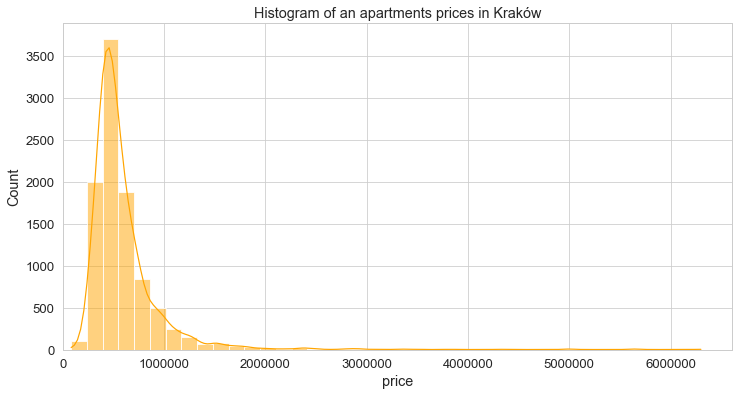

In [43]:
# Histogram of an apartments prices in Kraków
plt.figure(figsize=(12,6))

g = sns.histplot(x = 'price', data = df5[df5['city'] == "Kraków"], bins = 40, color = 'orange', 
                 kde = True)

g.set(xlim=(0, None))
g.set_title('Histogram of an apartments prices in Kraków')
plt.ticklabel_format(style='plain', axis='x')

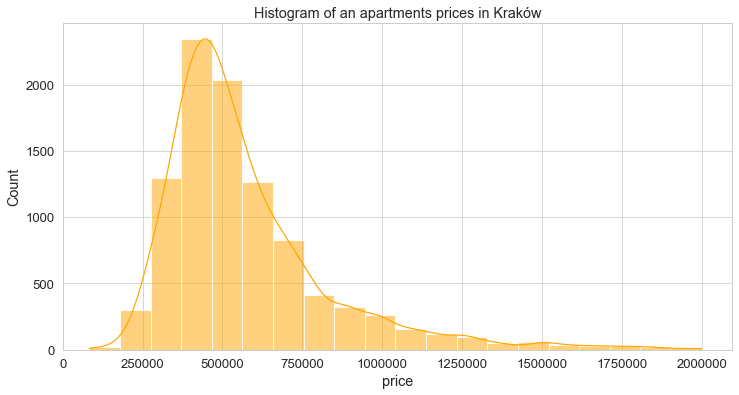

In [44]:
# Histogram of an apartments prices in Kraków closer look
plt.figure(figsize=(12,6))

g = sns.histplot(x = 'price', data = df5[(df5['city'] == "Kraków") & (df5['price'] < 2000000)], 
                 bins = 20, color = 'orange', kde = True)

g.set(xlim=(0, None))
g.set_title('Histogram of an apartments prices in Kraków')
plt.ticklabel_format(style='plain', axis='x')

<p>When it comes to the price of an apartment, in Cracow we have to pay an average of PLN 590.000.</p>

Text(0.5, 1.0, 'The size of the apartment [sqm] vs price')

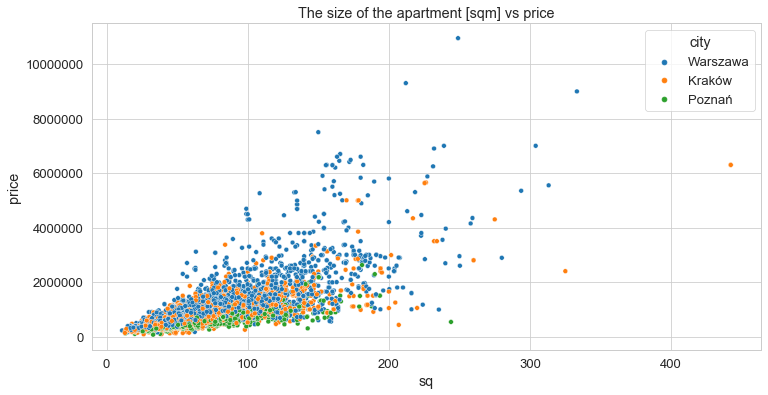

In [45]:
# Scatter plor of The size of the apartment [sqm] vs price'
plt.figure(figsize=(12,6))
plt.ticklabel_format(style='plain', axis='y')
g = sns.scatterplot(x = 'sq', y = 'price', data = df5, hue = 'city', 
                    hue_order = ['Warszawa', 'Kraków', 'Poznań'])
g.set_title('The size of the apartment [sqm] vs price')

Text(0.5, 1.0, 'The size of the apartment [sqm] vs price Poznań')

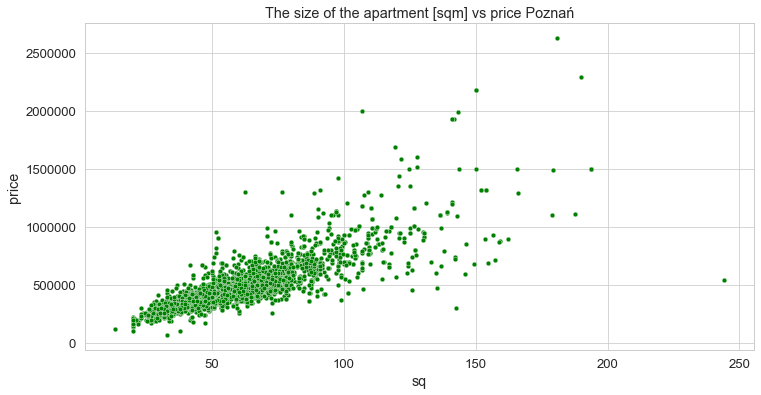

In [46]:
# Scatter plot The size of the apartment [sqm] vs price Poznań
plt.figure(figsize=(12,6))
plt.ticklabel_format(style='plain', axis='y')

g = sns.scatterplot(x='sq', y= 'price', data = df5[df5['city'] == "Poznań"], color = 'green')
g.set_title('The size of the apartment [sqm] vs price Poznań')

Text(0.5, 1.0, 'The size of the apartment [sqm] vs price Warszawa')

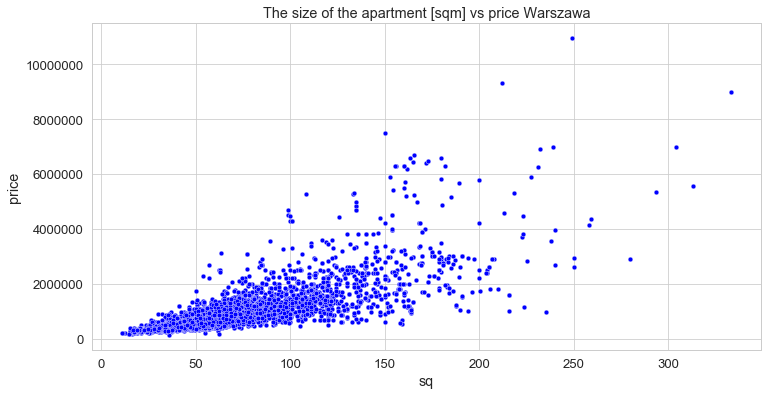

In [47]:
# Scatter plot The size of the apartment [sqm] vs price Warszawa
plt.figure(figsize=(12,6))
plt.ticklabel_format(style='plain', axis='y')

g = sns.scatterplot(x='sq', y= 'price', data = df5[df5['city'] == "Warszawa"], color = 'blue')
g.set_title('The size of the apartment [sqm] vs price Warszawa')

Text(0.5, 1.0, 'The size of the apartment [sqm] vs price Kraków')

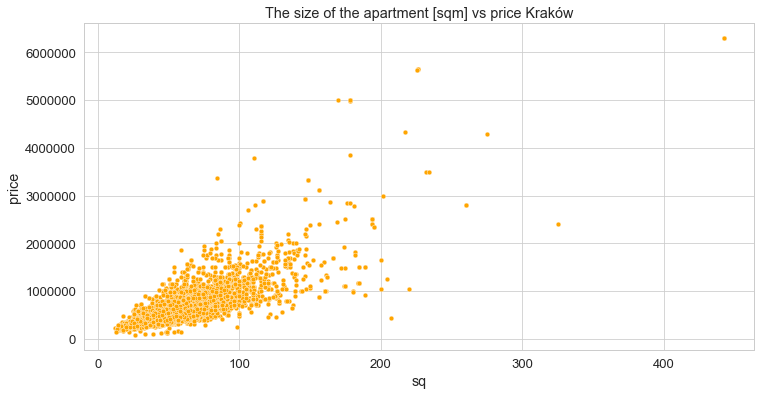

In [48]:
# Scatter plot The size of the apartment [sqm] vs price Kraków
plt.figure(figsize=(12,6))
plt.ticklabel_format(style='plain', axis='y')

g = sns.scatterplot(x='sq', y= 'price', data = df5[df5['city'] == "Kraków"], color = 'orange')
g.set_title('The size of the apartment [sqm] vs price Kraków')

<p>On the above scatter plots we can see regressions. As the size of the apartment increases, so does its price.</p>

<p>We can still notice outliers in each of the cities. They are often more exclusive flats, where, despite similar parameters, the flat can be in a very convenient location with very good modern equipment.</p>

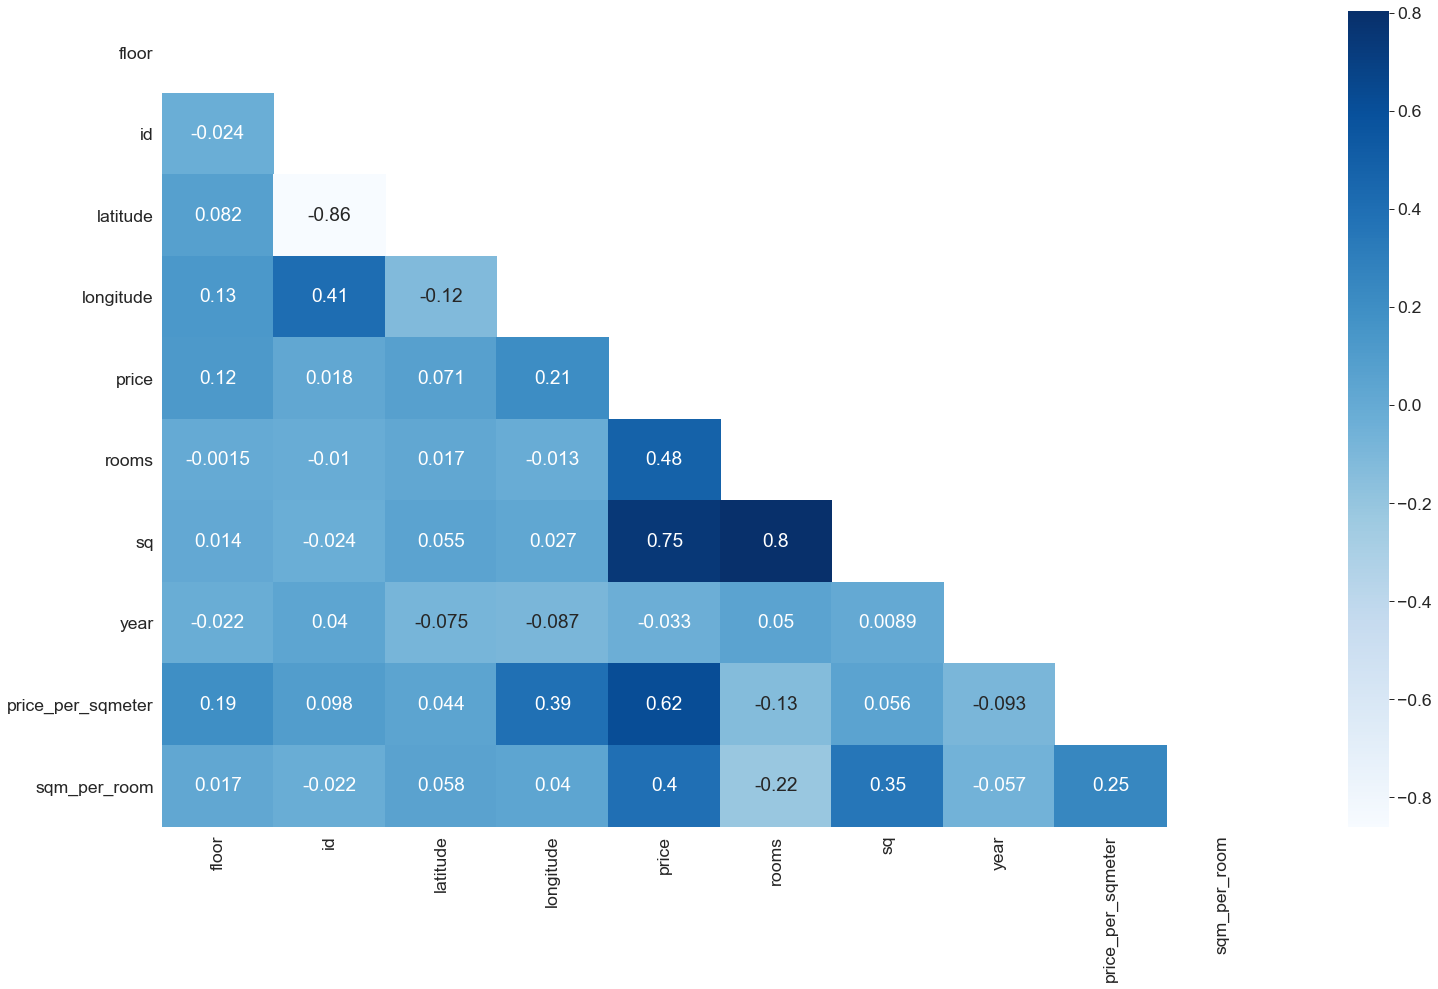

In [49]:
# Correlation heatmap
plt.figure(figsize=(25,15))
sns.set_context('paper', font_scale=2)

corr= df5.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='Blues', mask=mask)

<p>Take a look at the heatmap correlation. The most positive correlation is shown by the following 
variables: the number of square meters and the number of rooms in an apartment. 
Which makes sense, because the more rooms, the bigger the apartment is.</p>

<p>The second variable that strongly correlates with the number of square meters is the price, 
which also makes sense, because the larger the apartment, the greater its price. 
This has also been shown to us by scatter plots.</p>

Text(0.5, 1.0, 'Count of sales announcements by number of rooms in the apartment')

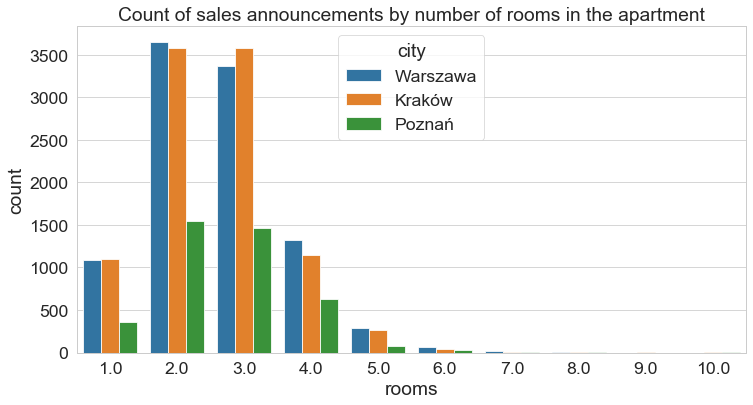

In [50]:
# Count of sales announcements by number of rooms in the apartment'
plt.figure(figsize=(12,6))
sns.countplot(x = 'rooms', hue_order = ['Warszawa', 'Kraków', 'Poznań'],
              data = df5, 
              hue = 'city').set_title('Count of sales announcements by number of rooms in the apartment')

<p>In the chart above, we can see that in each of the three cities, ads for two and three-room apartments have an advantage.</p>

Text(0.5, 1.0, 'Price vs Rooms')

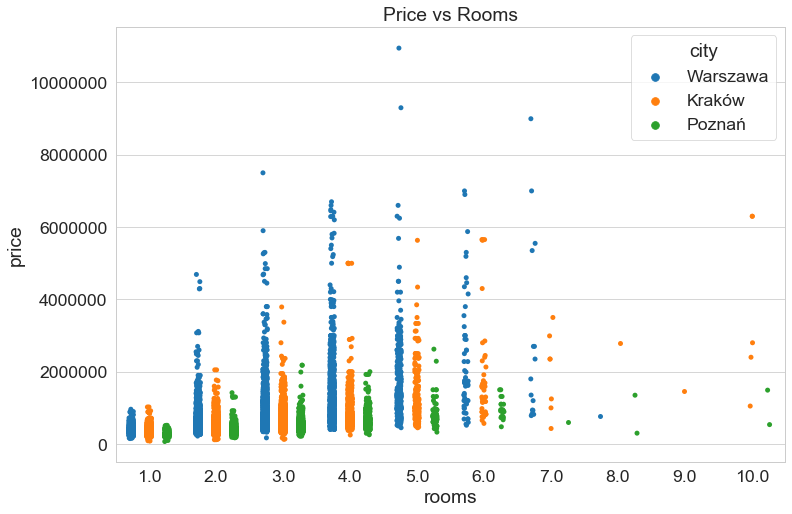

In [51]:
# Strip plot Price vs Rooms
plt.figure(figsize=(12,8))
plt.ticklabel_format(style='plain', axis='y')
sns.stripplot(x = 'rooms', data = df5, y = 'price', hue = 'city', jitter=True,
             hue_order = ['Warszawa', 'Kraków', 'Poznań'], dodge = True).set_title('Price vs Rooms')

<p>The chart above shows the price of flats in relation to the number of rooms.</p>
<p>We know that most of the ads are two or three-room apartments.
We can notice that their price, similarly to the other values of the number of rooms, is about PLN 500.000.</p>

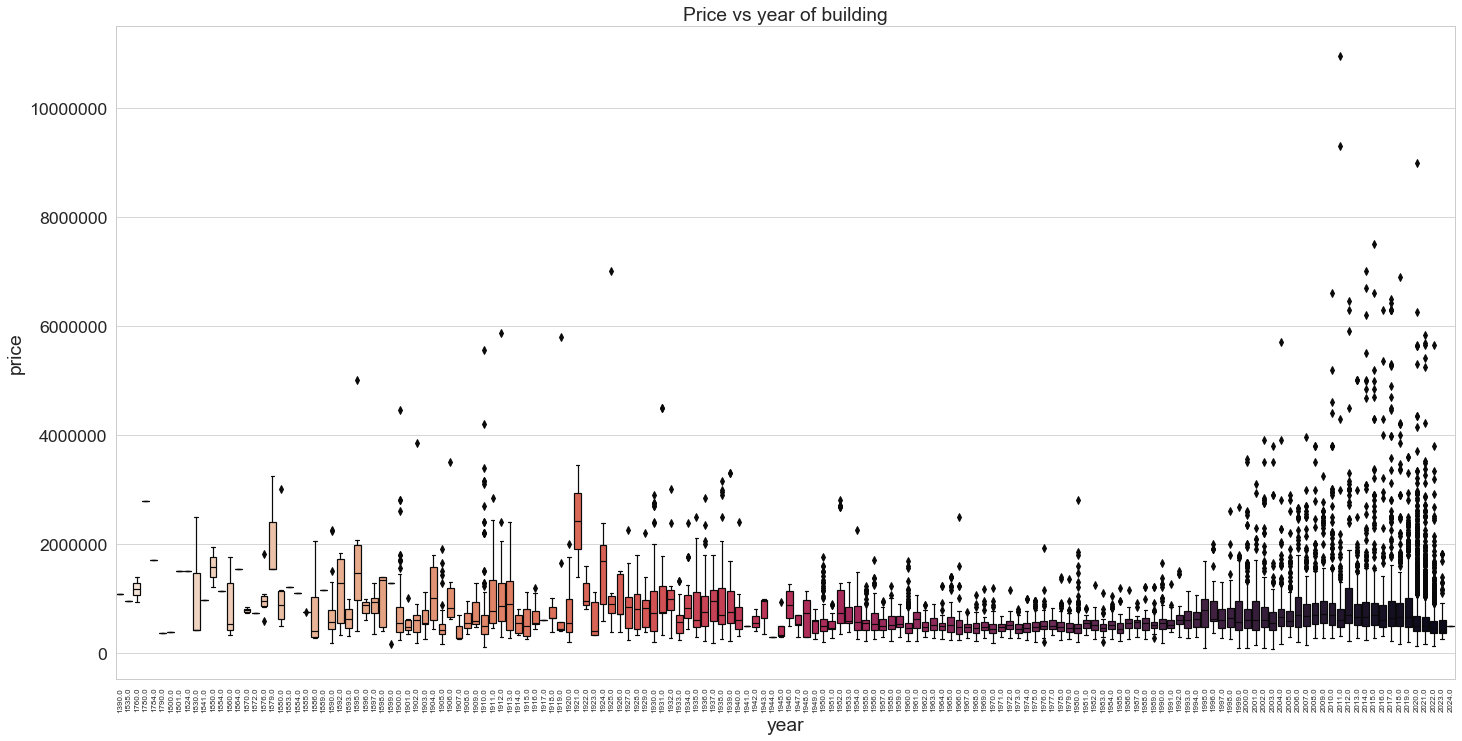

In [52]:
# Box plots Price vs year of building
plt.figure(figsize=(24,12))
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(fontsize=8, rotation=90)
g = sns.boxplot(x = 'year', data = df5, y = 'price', 
                palette = 'rocket_r').set_title('Price vs year of building')

<p>The graph shows the price vs the year of the building / apartment.
The oldest apartment is from 1390, probably in an old tenement house. The newest apartment is 2024, so it is probably planned to be built, but it is already possible to buy it. The average year of a building / apartment from all advertisements is 2001.</p>
<p>We can also notice that in newer flats in the 1995-2024 range, there are many outliers. It is probably related to previously mentioned exclusive apartments.</p>

In [53]:
df5[df5['year'] >= 2021].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
floor,7475.0,2.712508,2.352049,0.000000,1.000000,2.000000,4.000000,1.000000e+01
id,7475.0,16532.401070,9304.297585,18.000000,7634.000000,18362.000000,24747.500000,3.030800e+04
latitude,7475.0,51.178226,1.128346,49.982311,50.049893,50.104781,52.278512,5.258116e+01
longitude,7475.0,19.611829,1.475601,16.789775,19.894064,19.971430,20.952580,2.124921e+01
price,7475.0,545971.005280,306370.630828,134075.900000,385686.000000,479686.920000,625265.500000,5.829120e+06
rooms,7475.0,2.594916,0.949586,1.000000,2.000000,3.000000,3.000000,7.000000e+00
sq,7475.0,55.611252,21.737257,13.300000,40.210000,52.200000,66.855000,2.261400e+02
year,7475.0,2021.429164,0.521063,2021.000000,2021.000000,2021.000000,2022.000000,2.024000e+03
price_per_sqmeter,7475.0,9940.086605,2733.328182,3570.634921,8100.000000,9307.963734,11207.439410,3.499774e+04
sqm_per_room,7475.0,22.059241,5.004426,10.730000,18.500000,21.093333,24.285000,5.010333e+01


<p>Finally, let's look at the average values referring only to apartments from 2021 or newer.</p>
<p>We can say that the average price of a flat is PLN 546.000. It is a three-room apartment on the 3rd floor with an area of approximately 56 square meters.</p>

<span id = "5"></span>
# Apartments Location Heatmap

In [59]:
# Heatmap Warszawa

# list of all latitude 
waw_lat = df5[df5['city'] == "Warszawa"].latitude.tolist()
# list of all longitude 
waw_lng = df5[df5['city'] == "Warszawa"].longitude.tolist()
# matrix of all [[latitude,longitude], ...[]]
waw_data = np.column_stack((waw_lat, waw_lng))

m = folium.Map(location=[52.235, 21.035], zoom_start=11, tiles="Stamen Terrain")

HeatMap(waw_data).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))
folium.LayerControl().add_to(m)

m

In [61]:
# Heatmap Poznań

# list of all latitude 
pzn_lat = df5[df5['city'] == "Poznań"].latitude.tolist()
# list of all longitude 
pzn_lng = df5[df5['city'] == "Poznań"].longitude.tolist()
# matrix of all [[latitude,longitude], ...[]]
pzn_data = np.column_stack((pzn_lat, pzn_lng))

m = folium.Map(location=[52.4127903, 16.9222533], zoom_start=12, tiles="Stamen Terrain")

HeatMap(pzn_data).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))
folium.LayerControl().add_to(m)

m

In [63]:
# Heatmap Kraków

# list of all latitude 
krk_lat = df5[df5['city'] == "Kraków"].latitude.tolist()
# list of all longitude 
krk_lng = df5[df5['city'] == "Kraków"].longitude.tolist()
# matrix of all [[latitude,longitude], ...[]]
krk_data = np.column_stack((krk_lat, krk_lng))

m = folium.Map(location=[50.063367, 19.935186], zoom_start=12, tiles="Stamen Terrain")

HeatMap(krk_data).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))
folium.LayerControl().add_to(m)

m

<span id = "6"></span>
# Regression Model

In [57]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23646 entries, 0 to 23763
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   address            23646 non-null  object 
 1   city               23646 non-null  object 
 2   floor              23646 non-null  float64
 3   id                 23646 non-null  float64
 4   latitude           23646 non-null  float64
 5   longitude          23646 non-null  float64
 6   price              23646 non-null  float64
 7   rooms              23646 non-null  float64
 8   sq                 23646 non-null  float64
 9   year               23646 non-null  float64
 10  price_per_sqmeter  23646 non-null  float64
 11  sqm_per_room       23646 non-null  float64
dtypes: float64(10), object(2)
memory usage: 2.8+ MB


In [58]:
# one hot encoding on city
df6 = pd.get_dummies(df5, columns = ['city'])
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23646 entries, 0 to 23763
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   address            23646 non-null  object 
 1   floor              23646 non-null  float64
 2   id                 23646 non-null  float64
 3   latitude           23646 non-null  float64
 4   longitude          23646 non-null  float64
 5   price              23646 non-null  float64
 6   rooms              23646 non-null  float64
 7   sq                 23646 non-null  float64
 8   year               23646 non-null  float64
 9   price_per_sqmeter  23646 non-null  float64
 10  sqm_per_room       23646 non-null  float64
 11  city_Kraków        23646 non-null  uint8  
 12  city_Poznań        23646 non-null  uint8  
 13  city_Warszawa      23646 non-null  uint8  
dtypes: float64(10), object(1), uint8(3)
memory usage: 2.7+ MB


In [59]:
# setting X with columns important to the model and y
X = df6.drop(['address', 'id', 'latitude', 'longitude', 'price', 'price_per_sqmeter', 'sqm_per_room'], axis =1)
y = df6['price']

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23646 entries, 0 to 23763
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   floor          23646 non-null  float64
 1   rooms          23646 non-null  float64
 2   sq             23646 non-null  float64
 3   year           23646 non-null  float64
 4   city_Kraków    23646 non-null  uint8  
 5   city_Poznań    23646 non-null  uint8  
 6   city_Warszawa  23646 non-null  uint8  
dtypes: float64(4), uint8(3)
memory usage: 1.5 MB


In [61]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [62]:
# xgboost 
regressor=xgboost.XGBRegressor()

In [63]:
## Hyper Parameter Optimization

n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [64]:
# Set up the random search with 4-fold cross validation

random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [65]:
# fit the train data
# random_cv.fit(X_train, y_train)

In [66]:
# checking best estimator
# random_cv.best_estimator_

In [67]:
# define regressor with the best estimator
regressor = xgboost.XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=900, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [68]:
# fit the train data
regressor.fit(X_train, y_train)

XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=900, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<span id = "7"></span>
# Model Evaluation

In [69]:
# predict the price for test data
y_pred =regressor.predict(X_test)

In [70]:
print("\tModel Evaluation")
print('\n')
print('mean_absolute_error:')
print(mean_absolute_error(y_test, y_pred))
print('\n')
print('sqrt mean_squared_error:')
print(np.sqrt(mean_squared_error(y_test,y_pred)))
print('\n')
print('r2_score:')
print(r2_score(y_test,y_pred))
print('\n')
print('explained_variance_score:')
print(explained_variance_score(y_test,y_pred))

	Model Evaluation


mean_absolute_error:
88180.63160622759


sqrt mean_squared_error:
221699.42312854264


r2_score:
0.7675412501074144


explained_variance_score:
0.7675464188125117


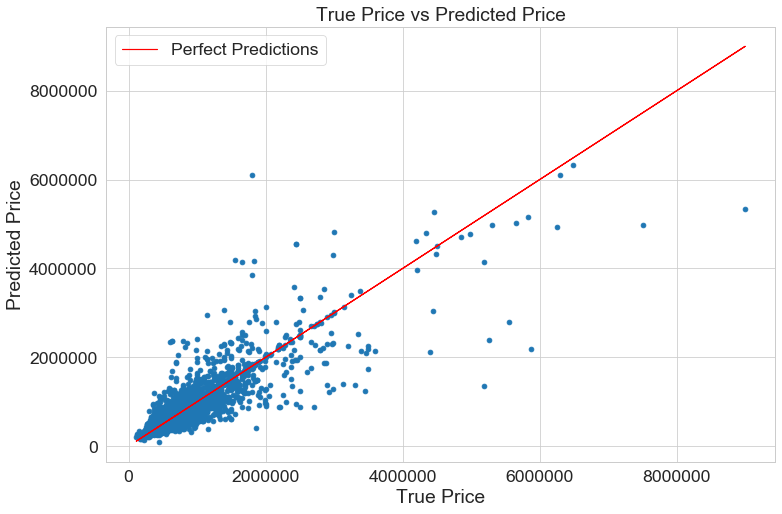

In [71]:
# Our predictions
plt.figure(figsize=(12,8))
plt.scatter(y_test,y_pred)

# Perfect predictions
line = plt.plot(y_test,y_test,'r')

# labels
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('True Price vs Predicted Price')
plt.legend(line, ['Perfect Predictions']);

In [72]:
# mean price for a apartment
df5['price'].mean()

641818.6321991031

In [73]:
# MAE * 100 / (mean price for a apartment)
mean_absolute_error(y_test, y_pred) * 100 / df5['price'].mean()

# we off by around 13,7 %

13.739182252171272

In [74]:
# end